# Utility Functions

In [ ]:
!pip install -U tf-keras-vis

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import activations

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    acc = smooth_curve(history.history['accuracy'][:steps])
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

# Building a Convolutional Neural Network

## Imagen Data

In [ ]:
from google.colab import drive
import os
import shutil
import random

# Montar Google Drive
drive.mount('/content/drive')

# Definir la ruta base de las carpetas originales en Google Drive
base_dir = '/content/drive/My Drive/flowers'  # Cambia 'flowers' a la ruta correcta en tu Google Drive

# Crear las rutas para las carpetas de ENTRENAMIENTO, VALIDACIÓN y PRUEBA
train_dir = os.path.join(base_dir, 'ENTRENAMIENTO')
val_dir = os.path.join(base_dir, 'VALIDACIÓN')
test_dir = os.path.join(base_dir, 'PRUEBA')

# Crear las subcarpetas dentro de ENTRENAMIENTO, VALIDACIÓN y PRUEBA para TULIPAN y ROSE
os.makedirs(os.path.join(train_dir, 'TULIPAN'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'ROSE'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'TULIPAN'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'ROSE'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'TULIPAN'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'ROSE'), exist_ok=True)

# Función para mover imágenes a las carpetas correspondientes
def split_data(src_dir, class_name, train_dir, val_dir, test_dir, train_size=70, val_size=15, test_size=15):
    # Listar todos los archivos de imágenes en la carpeta
    files = os.listdir(src_dir)

    # Filtrar solo los archivos de imágenes
    image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]

    # Asegurarse de que haya exactamente 100 imágenes
    if len(image_files) != 100:
        raise ValueError(f"Se esperaban 100 imágenes en {src_dir}, pero se encontraron {len(image_files)}.")

    # Mezclar aleatoriamente las imágenes
    random.shuffle(image_files)

    # Seleccionar imágenes para cada conjunto
    train_files = image_files[:train_size]
    val_files = image_files[train_size:train_size + val_size]
    test_files = image_files[train_size + val_size:train_size + val_size + test_size]

    # Mover archivos a las carpetas correspondientes
    for file in train_files:
        shutil.move(os.path.join(src_dir, file), os.path.join(train_dir, class_name, file))

    for file in val_files:
        shutil.move(os.path.join(src_dir, file), os.path.join(val_dir, class_name, file))

    for file in test_files:
        shutil.move(os.path.join(src_dir, file), os.path.join(test_dir, class_name, file))

# Aplicar la función para "TULIPAN" y "ROSE"
split_data(os.path.join(base_dir, 'TULIPAN'), 'TULIPAN', train_dir, val_dir, test_dir)
split_data(os.path.join(base_dir, 'ROSE'), 'ROSE', train_dir, val_dir, test_dir)


## Model Definition

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling2D)             │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_2 (MaxPooling2D)             │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_3 (MaxPooling2D)             │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_4 (Conv2D)                      │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_4 (MaxPooling2D)             │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,150,145 (65.42 MB)

 Trainable params: 17,150,145 (65.42 MB)

 Non-trainable params: 0 (0.00 B)

## Data Generator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 140 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


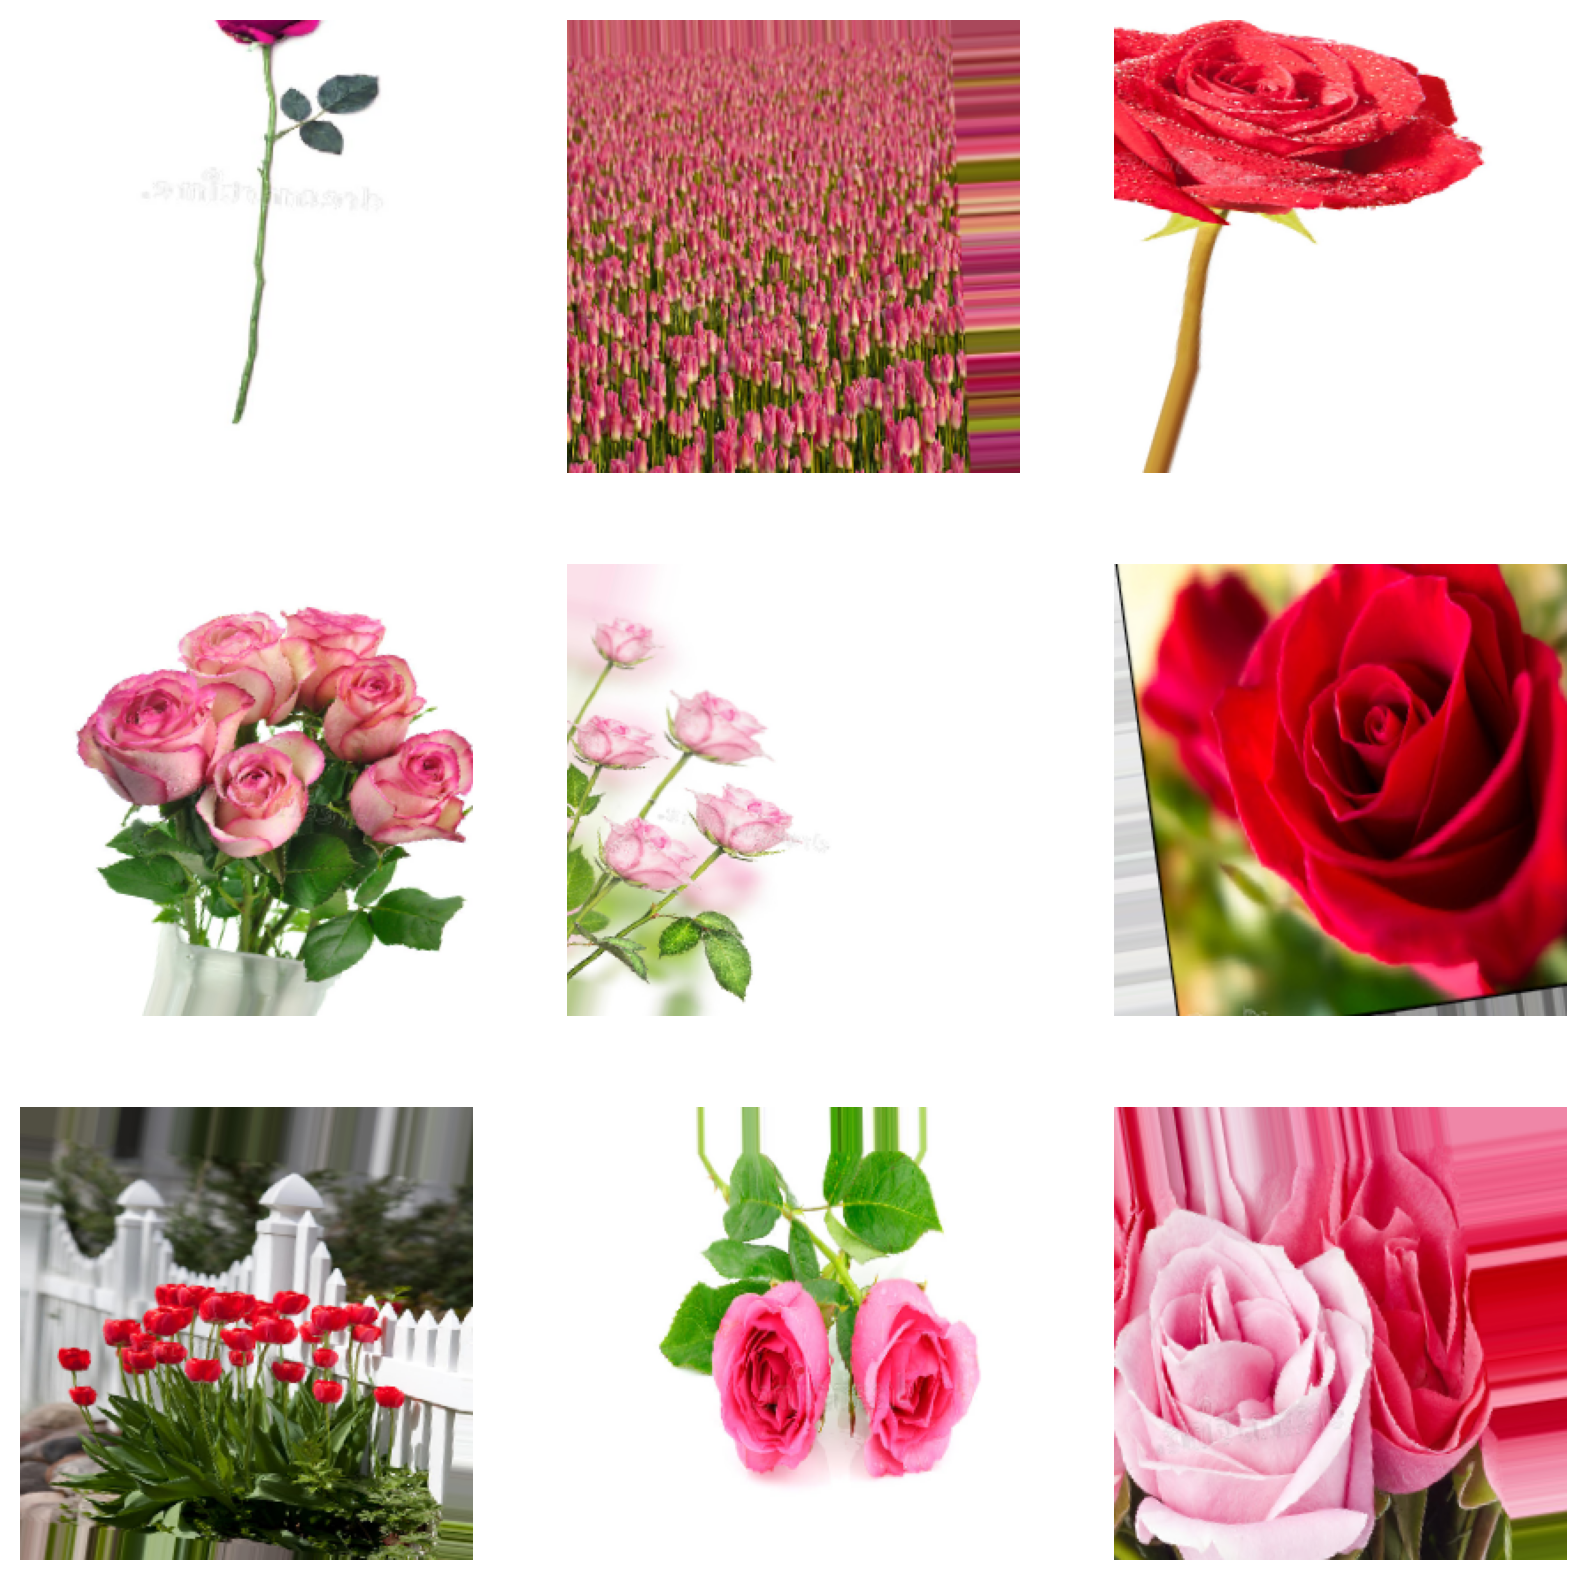

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# Definir el tamaño de las imágenes y el tamaño del batch
tamanio_imagen = (256, 256)
batch_size = 32

# Crear instancias de ImageDataGenerator con augmentación para entrenamiento
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Instancia de ImageDataGenerator para validación y prueba
datagen_val_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Configurar el flujo de datos para entrenamiento, validación y prueba
entrenamiento_generator = datagen_train.flow_from_directory(
    '/content/drive/My Drive/flowers/ENTRENAMIENTO',
    target_size=tamanio_imagen,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

validacion_generator = datagen_val_test.flow_from_directory(
    '/content/drive/My Drive/flowers/VALIDACIÓN',
    target_size=tamanio_imagen,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

prueba_generator = datagen_val_test.flow_from_directory(
    '/content/drive/My Drive/flowers/PRUEBA',
    target_size=tamanio_imagen,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Visualizar algunas imágenes de entrenamiento
x_batch, y_batch = next(entrenamiento_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()


## Training

In [ ]:
history = model.fit(entrenamiento_generator, steps_per_epoch=100, epochs=20, validation_data=validacion_generator, validation_steps=50, verbose=1)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.4366 - loss: 0.9267 - val_accuracy: 0.5000 - val_loss: 0.6957
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5015 - loss: 0.6969 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4566 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5011 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6146 - loss: 0.6906 - val_accuracy: 0.8333 - val_loss: 0.6801
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5933 - loss: 0.6827 - val_accuracy: 0.5000 - val_loss: 0.6458
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5862 - loss: 0.6995 - val_accuracy: 0.6333 - val_loss: 0.6547
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6559 - loss: 0.6519 - val_accuracy: 

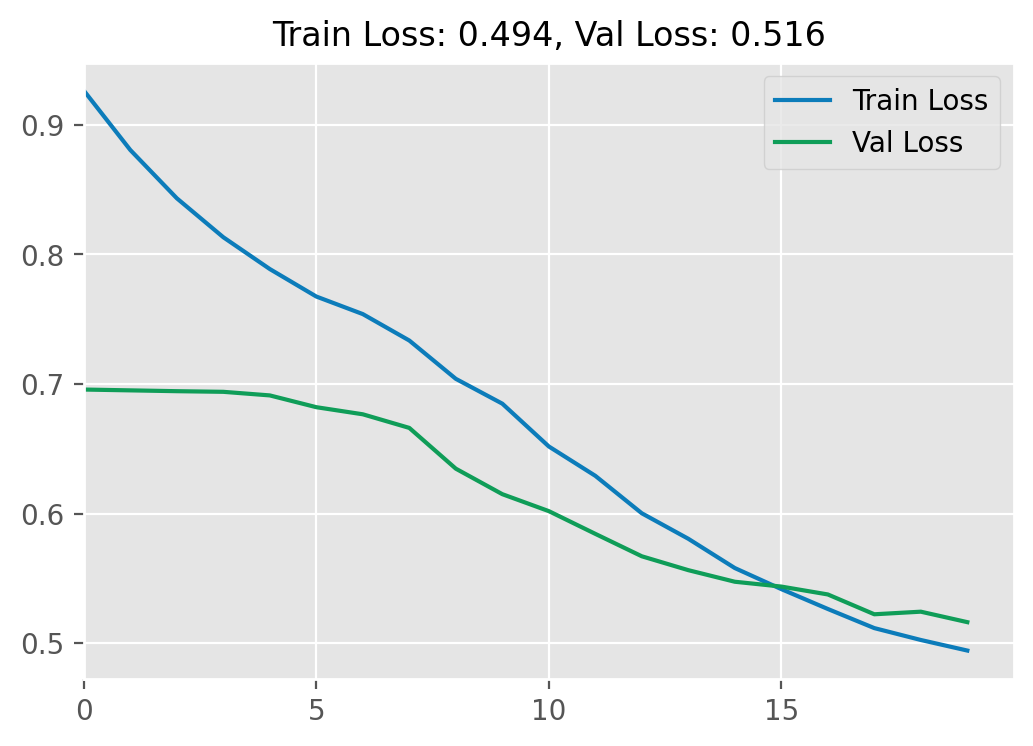

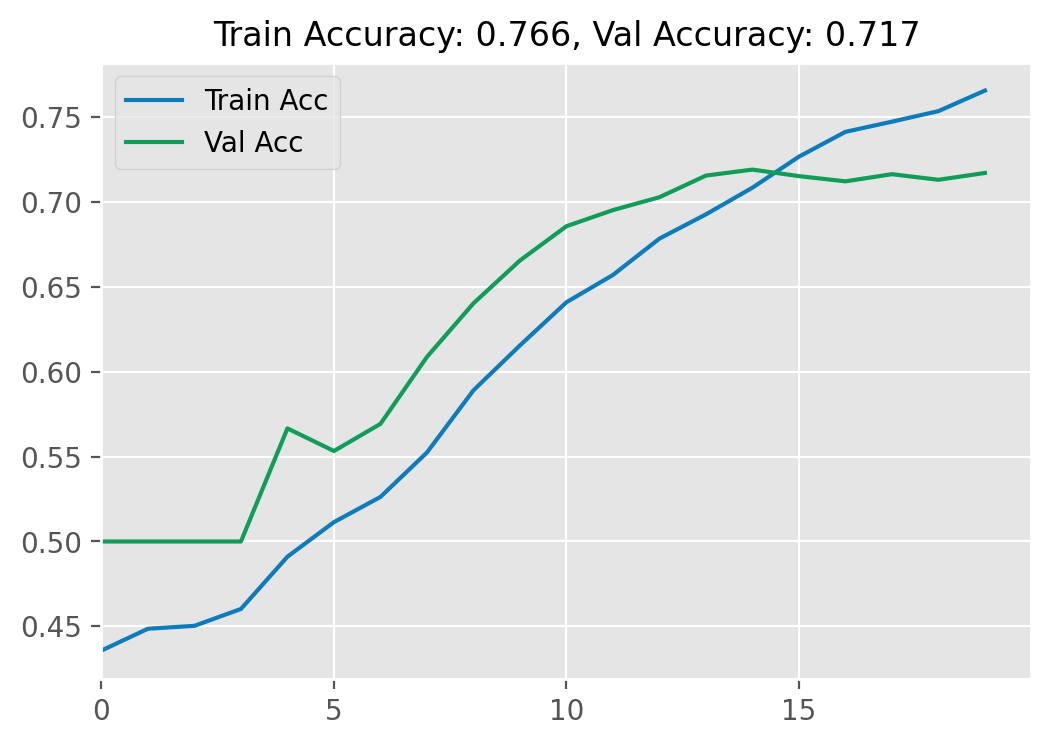

In [ ]:
plot_compare(history)

## Data Augmentation

In [ ]:
model_1 = Sequential()
model_1.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',input_shape=(256, 256, 3)))
model_1.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_1.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_1.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_1.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_1.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_1.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_1.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_1.add(Flatten())
model_1.add(Dropout(0.5))
model_1.add(Dense(512, activation='relu', name='dense_1'))
model_1.add(Dense(256, activation='relu', name='dense_2'))
model_1.add(Dense(1, activation='sigmoid', name='output'))

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
entrenamiento_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

prueba_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

entrenamiento_generador = entrenamiento_datagen.flow_from_directory(
        '/content/drive/My Drive/flowers/ENTRENAMIENTO',
        target_size=tamanio_imagen,
        batch_size=batch_size,
        class_mode='binary')

validacion_generador = prueba_datagen.flow_from_directory(
        '/content/drive/My Drive/flowers/VALIDACIÓN',
        target_size=tamanio_imagen,
        batch_size=batch_size,
        class_mode='binary')

# early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
history_1 = model_1.fit(entrenamiento_generador,
                        steps_per_epoch=100,
                        epochs=60,
                        validation_data=validacion_generador,
                        validation_steps=50,
                        verbose=1)

Found 140 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Epoch 1/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.5436 - loss: 1.0733 - val_accuracy: 0.5000 - val_loss: 0.6990
Epoch 2/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4846 - loss: 0.6967 - val_accuracy: 0.5000 - val_loss: 0.7102
Epoch 3/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5080 - loss: 0.7002 - val_accuracy: 0.5000 - val_loss: 0.6903
Epoch 4/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4995 - loss: 0.6957 - val_accuracy: 0.5000 - val_loss: 0.6904
Epoch 5/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5027 - loss: 0.6922 - val_accuracy: 0.6667 - val_loss: 0.6869
Epoch 6/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5875 - loss: 0.6882 - val_accuracy: 0.6667 - val_loss: 0.6625
Epoch 7/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6412 - loss: 0.6529 - val_accuracy: 0.5000 - val_loss: 0.6959
Epoch 8/60
100/100 ━━

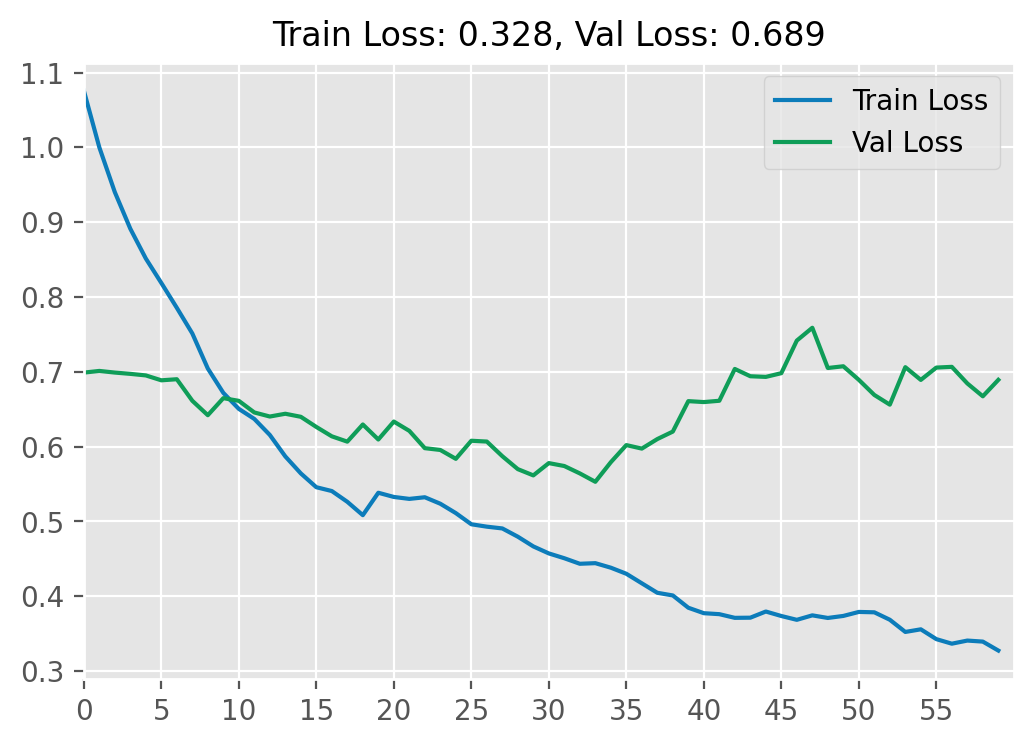

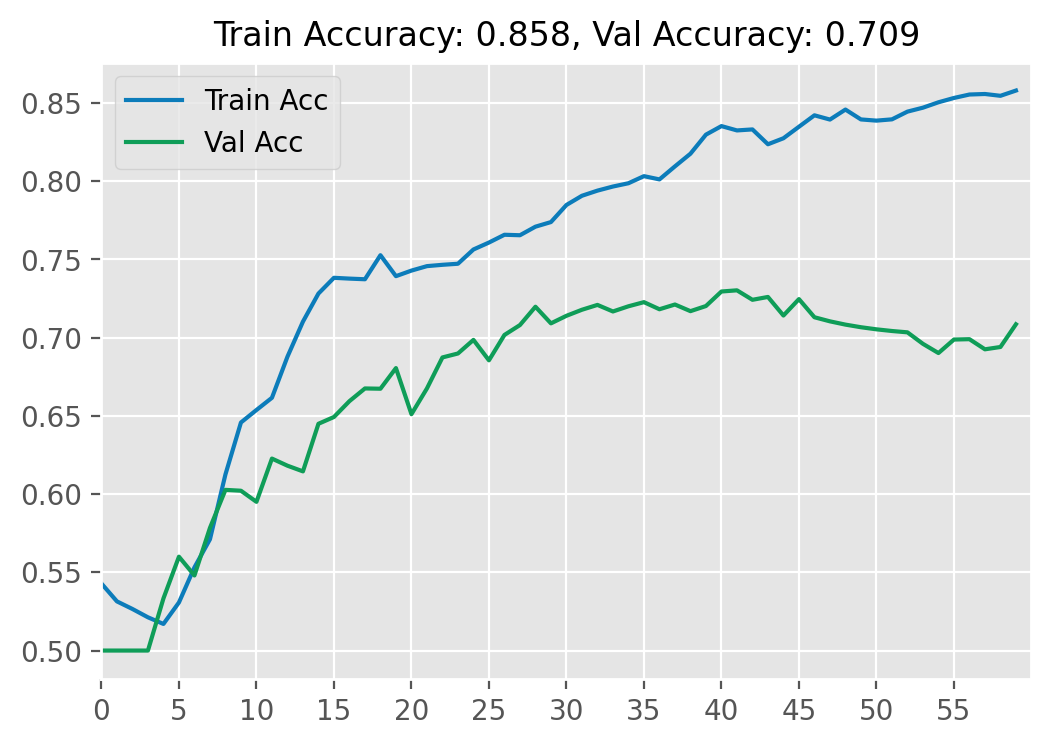

In [ ]:
plot_compare(history_1)

In [ ]:
model.save('modelo.h5')
save_history(history_1, 'history.bin')

# TEST

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


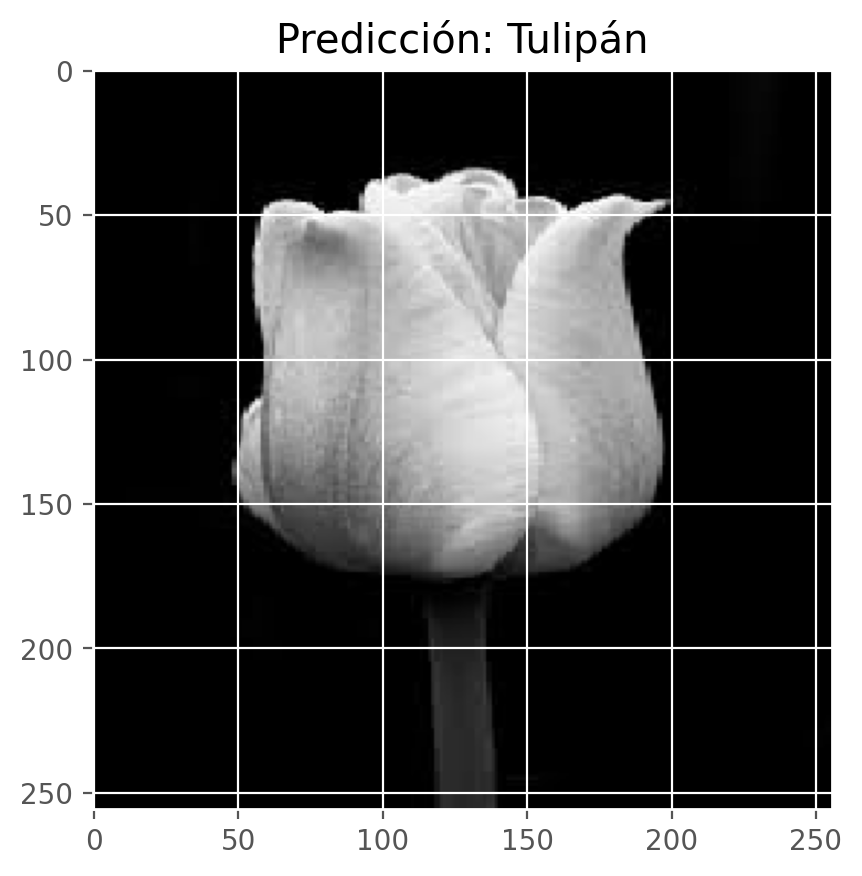

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Guardar el modelo entrenado en Google Drive
model.save('/content/drive/My Drive/carpeta_con_modelo/modelo_entrenado.h5')

# Paso 1: Cargar el modelo entrenado
model = tf.keras.models.load_model('/content/drive/My Drive/carpeta_con_modelo/modelo_entrenado.h5')

# Paso 2: Montar Google Drive (si no está montado ya)
from google.colab import drive
drive.mount('/content/drive')

# Paso 3: Seleccionar una imagen al azar desde Google Drive
image_folder = '/content/drive/My Drive/FLORES/'  # Cambia esta ruta a tu carpeta de imágenes
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
selected_image = random.choice(image_files)
image_path = os.path.join(image_folder, selected_image)

# Paso 4: Preprocesar la imagen (por ejemplo, si el modelo espera 256x256)
img = image.load_img(image_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión para el batch
img_array = img_array / 255.0  # Normalizar si es necesario

# Paso 5: Realizar la predicción usando el modelo cargado
prediccion = model.predict(img_array, verbose=0)

# Asumimos que una predicción < 0.5 corresponde a 'Tulipán' y >= 0.5 a 'Rosa'
if prediccion[0][0] < 0.5:
    predicted_label = 'Tulipán'
else:
    predicted_label = 'Rosa'

# Paso 6: Mostrar la imagen junto con la predicción
plt.imshow(img)
plt.title(f'Predicción: {predicted_label}')
plt.show()

# EXAMPLES

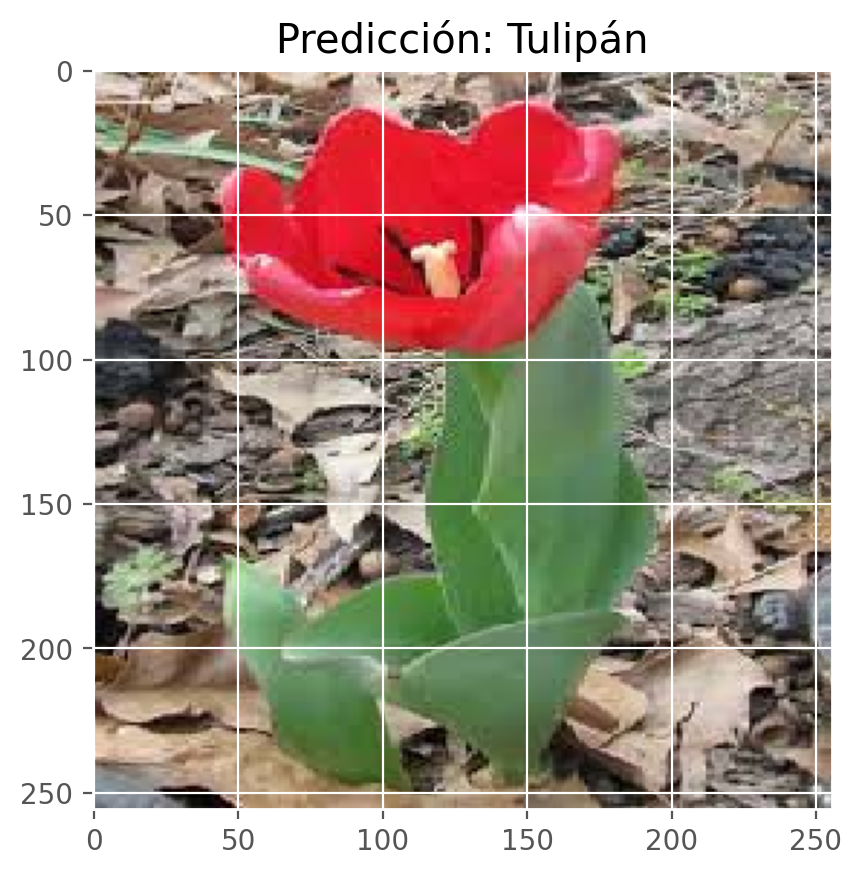

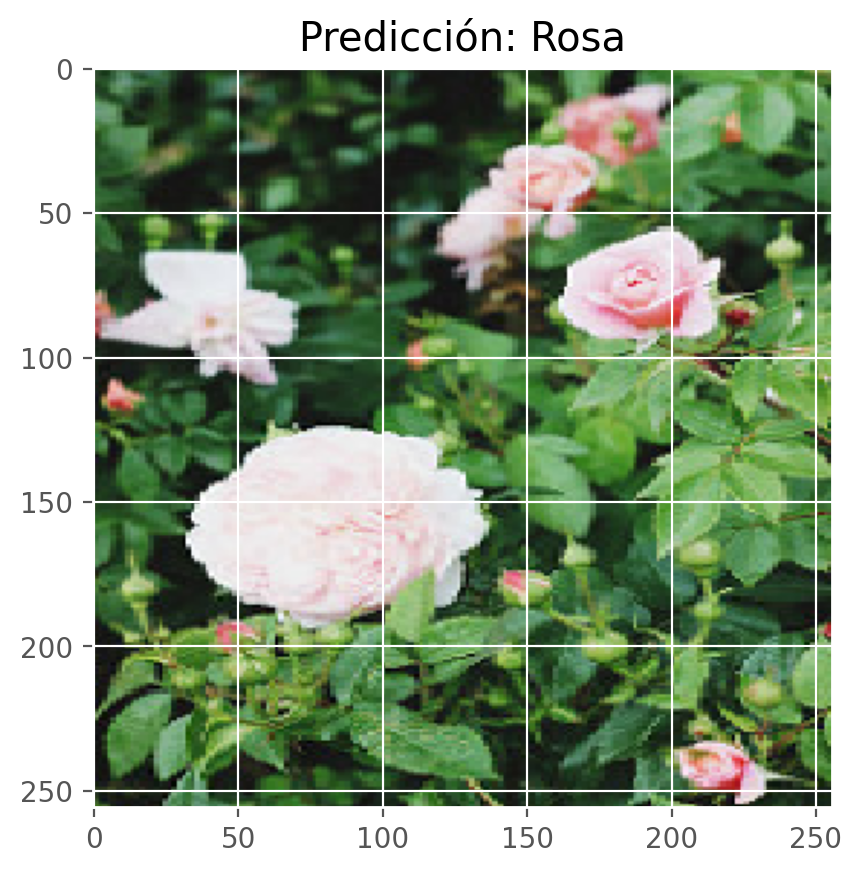

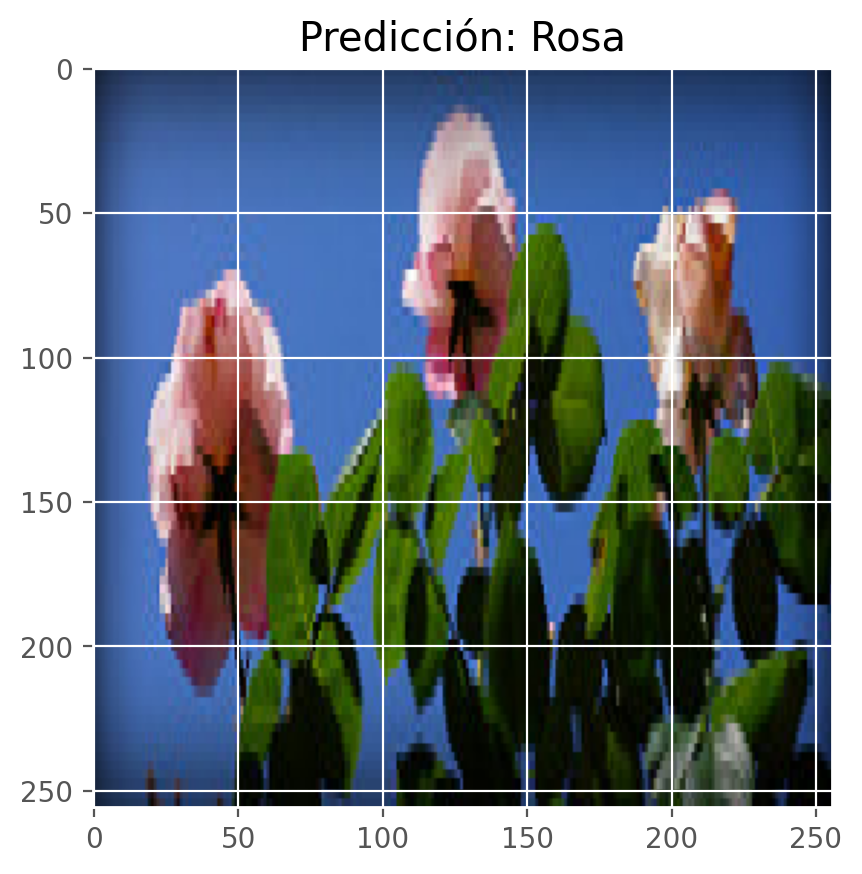

In [ ]:
# Ejemplo 1: Mostrar TRES imágenes aleatorias y sus predicciones

# Seleccionar cinco imágenes aleatorias en la carpeta
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
random_images = random.sample(image_files, 3)

for image_file in random_images:
    image_path = os.path.join(image_folder, image_file)

    # Preprocesar la imagen
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Realizar la predicción
    prediccion = model.predict(img_array, verbose=0)

    # Determinar la clase predicha
    if prediccion[0][0] < 0.5:
        predicted_label = 'Tulipán'
    else:
        predicted_label = 'Rosa'

    # Mostrar la imagen junto con la predicción
    plt.imshow(img)
    plt.title(f'Predicción: {predicted_label}')
    plt.show()
